# Network Visualization (TensorFlow)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **TensorFlow**; we have provided another notebook which explores the same concepts in PyTorch. You only need to complete one of these two notebooks.

In [1]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/mayuxiang/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

We have ported the PyTorch SqueezeNet model to TensorFlow; see: `cs231n/classifiers/squeezenet.py` for the model architecture.

To use SqueezeNet, you will need to first **download the weights** by descending into the `cs231n/datasets` directory and running `get_squeezenet_tf.sh`. Note that if you ran `get_assignment3_data.sh` then SqueezeNet will already be downloaded.

Once you've downloaded the Squeezenet model, we can load it into a new TensorFlow session:

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [2]:
tf.reset_default_graph()
sess = get_session()

SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
if not os.path.exists(SAVE_PATH + ".index"):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

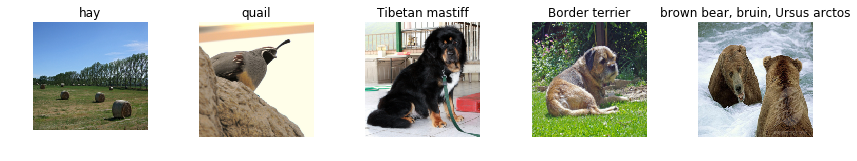

In [3]:
from cs231n.data_utils import load_imagenet_val
X_raw, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Preprocess images
The input to the pretrained model is expected to be normalized, so we first preprocess the images by subtracting the pixelwise mean and dividing by the pixelwise standard deviation.

In [4]:
X = np.array([preprocess_image(img) for img in X_raw])

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `model.scores` Tensor containing the scores for each input, and will need to feed in values for the `model.image` and `model.labels` placeholder when evaluating the gradient. Open the file `cs231n/classifiers/squeezenet.py` and read the documentation to make sure you understand how to use the model. For example usage, you can see the `loss` attribute. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [5]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.scores,
                                  tf.stack((tf.range(X.shape[0]), model.labels), axis=1))
    ###############################################################################
    # TODO: Produce the saliency maps over a batch of images.                     #
    #                                                                             #
    # 1) Compute the “loss” using the correct scores tensor provided for you.     #
    #    (We'll combine losses across a batch by summing)                         #
    # 2) Use tf.gradients to compute the gradient of the loss with respect        #
    #    to the image (accessible via model.image).                               #
    # 3) Compute the actual value of the gradient by a call to sess.run().        #
    #    You will need to feed in values for the placeholders model.image and     #
    #    model.labels.                                                            #
    # 4) Finally, process the returned gradient to compute the saliency map.      #
    ###############################################################################
    loss = np.square(1 - correct_scores)
    grads = tf.gradients(loss, model.image)
    
    
       # p = sess.run(1)
    grads_out = sess.run(grads, feed_dict={model.image:X, model.labels:y})[0]
    
    #losses = tf.square(1 - correct_scores)
    
    #print(grads_out[0].shape)
    #saliency = np.max(grads_out, axis=-1)
    saliency = np.max(np.maximum(grads_out,0),axis=-1)
    print(saliency.shape)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

(5, 224, 224)


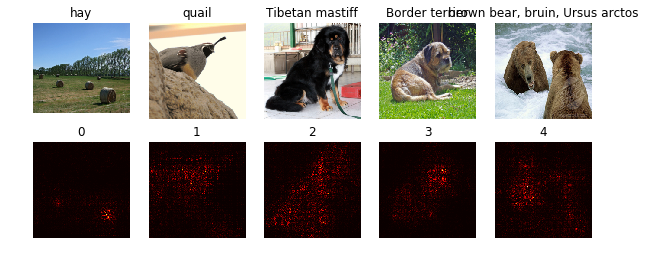

In [6]:
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

mask = np.arange(5)
show_saliency_maps(X, y, mask)

# INLINE QUESTION

A friend of yours suggests that in order to find an image that maximizes the correct score, we can perform gradient ascent on the input image, but instead of the gradient we can actually use the saliency map in each step to update the image. Is this assertion true? Why or why not?

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [7]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image, a numpy array of shape (1, 224, 224, 3)
    - target_y: An integer in the range [0, 1000)
    - model: Pretrained SqueezeNet model

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    
    # Make a copy of the input that we will modify
    X_fooling = X.copy()
    
    # Step size for the update
    learning_rate = 1
    iteration = 100
    
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. Use gradient *ascent* on the target class score, using #
    # the model.scores Tensor to get the class scores for the model.image.   #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop, where in each iteration, you make an     #
    # update to the input image X_fooling (don't modify X). The loop should      #
    # stop when the predicted class for the input is the same as target_y.       #
    #                                                                            #
    # HINT: It's good practice to define your TensorFlow graph operations        #
    # outside the loop, and then just make sess.run() calls in each iteration.   #
    #                                                                            #
    # HINT 2: For most examples, you should be able to generate a fooling image  #
    # in fewer than 100 iterations of gradient ascent. You can print your        #
    # progress over iterations to check your algorithm.                          #
    ##############################################################################
   
    grad_x = tf.gradients(model.scores[0, target_y], model.image)

    #grad_img = tf.gradients(model.classifier[0,target_y], model.image)[0]
 
    for i in range(iteration):
         
        scores = sess.run(model.scores, feed_dict = {model.image: X_fooling})
        print('step:%d, current_label:%d, target_label:%d' % \
              (i, np.argmax(scores[0]), target_y))
        if np.argmax(scores[0]) == target_y:
            break
            
        dx = sess.run(grad_x, feed_dict={model.image:X_fooling})
        dx = dx[0]
        X_fooling += learning_rate * dx /  np.sum(dx)
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

Run the following to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

step:0, current_label:85, target_label:6
step:1, current_label:85, target_label:6
step:2, current_label:84, target_label:6
step:3, current_label:6, target_label:6


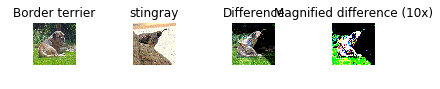

In [8]:
idx = 3
Xi = X[idx][None]
X_prim = X[1][None]
target_y = 6
X_fooling = make_fooling_image(X_prim, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = sess.run(model.scores, {model.image: X_fooling})
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
plt.axis('off')
plt.gcf().tight_layout()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = {\arg\max}_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [9]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

In [26]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 500)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    
    # We use a single image of random noise as a starting point
    X = 255 * np.random.rand(224, 224, 3)
    X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.scores to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    
    print(model.scores.shape)
    print(model.image.shape)
    
    loss = model.scores[0]
    #loss = (model.scores - l2_reg* tf.reduce_sum(model.image * model.image))[0]
    # input X is one image, so the index of output we focus on is the only one also the first one '0'
    grad = tf.gradients(model.scores[0, target_y], model.image)[0]  - l2_reg*model.image
    print(grad.shape)
    
    #loss = tf.argmax(loss_i - l2_reg * tf.reduce_sum(model.image * model.image))
    # scalar loss
    #grad_x = tf.gradients(model.scores[0, target_y], model.image)
    # gradient of loss with respect to model.image, same size as model.image
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        X = np.roll(np.roll(X, ox, 1), oy, 2)
        
        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        
        loss_val = sess.run(loss, feed_dict={model.image:X})
        grad_val = sess.run(grad, feed_dict={model.image:X})
        
        X += learning_rate * grad_val
        
        print('step:%d,current_label_score:%f,target_label_score:%f' % \
              (t, loss_val.max(), loss_val[target_y]))
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(X[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return X

Once you have completed the implementation in the cell above, run the following cell to generate an image of Tarantula:

(?, 1000)
(?, ?, ?, 3)
(?, ?, ?, 3)
step:0,current_label_score:-241.898849,target_label_score:-249.418549


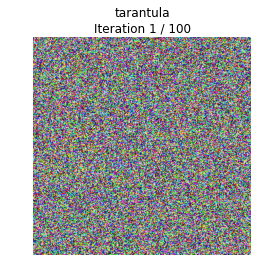

step:1,current_label_score:-101.159714,target_label_score:-106.852509
step:2,current_label_score:-99.322639,target_label_score:-105.760025
step:3,current_label_score:-99.592827,target_label_score:-105.292053
step:4,current_label_score:-100.545525,target_label_score:-104.533203
step:5,current_label_score:-99.668831,target_label_score:-103.742516
step:6,current_label_score:-103.621780,target_label_score:-105.161957
step:7,current_label_score:-101.351509,target_label_score:-102.451309
step:8,current_label_score:-102.840294,target_label_score:-102.840294
step:9,current_label_score:-100.882675,target_label_score:-100.882675
step:10,current_label_score:-103.367310,target_label_score:-103.367310
step:11,current_label_score:-56.499554,target_label_score:-56.499554
step:12,current_label_score:-57.457550,target_label_score:-57.457550
step:13,current_label_score:-66.478729,target_label_score:-66.478729
step:14,current_label_score:-74.575310,target_label_score:-74.575310
step:15,current_label_scor

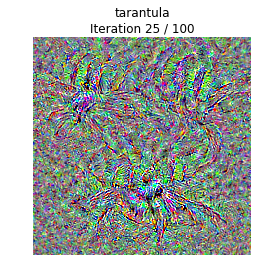

step:25,current_label_score:-69.382164,target_label_score:-69.382164
step:26,current_label_score:-63.277496,target_label_score:-63.277496
step:27,current_label_score:-67.986801,target_label_score:-67.986801
step:28,current_label_score:-79.216782,target_label_score:-79.216782
step:29,current_label_score:-70.203773,target_label_score:-70.203773
step:30,current_label_score:-80.708618,target_label_score:-80.708618
step:31,current_label_score:-16.934135,target_label_score:-16.934135
step:32,current_label_score:-39.256859,target_label_score:-39.256859
step:33,current_label_score:-60.295059,target_label_score:-60.295059
step:34,current_label_score:-65.169983,target_label_score:-65.169983
step:35,current_label_score:-82.101318,target_label_score:-82.101318
step:36,current_label_score:-73.800941,target_label_score:-73.800941
step:37,current_label_score:-72.740120,target_label_score:-72.740120
step:38,current_label_score:-78.477509,target_label_score:-78.477509
step:39,current_label_score:-83.56

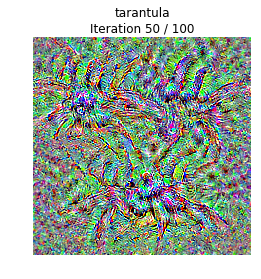

step:50,current_label_score:-81.515396,target_label_score:-81.515396
step:51,current_label_score:-12.370941,target_label_score:-12.370941
step:52,current_label_score:-42.162743,target_label_score:-42.162743
step:53,current_label_score:-44.491241,target_label_score:-44.491241
step:54,current_label_score:-58.589005,target_label_score:-58.589005
step:55,current_label_score:-58.472122,target_label_score:-58.472122
step:56,current_label_score:-70.427948,target_label_score:-70.427948
step:57,current_label_score:-67.136703,target_label_score:-67.136703
step:58,current_label_score:-68.219208,target_label_score:-68.219208
step:59,current_label_score:-99.629173,target_label_score:-99.629173
step:60,current_label_score:-86.020844,target_label_score:-86.020844
step:61,current_label_score:-7.026947,target_label_score:-7.026947
step:62,current_label_score:-73.838585,target_label_score:-73.838585
step:63,current_label_score:-72.503098,target_label_score:-72.503098
step:64,current_label_score:-69.1094

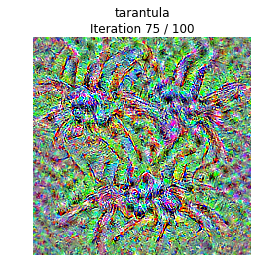

step:75,current_label_score:-73.442612,target_label_score:-73.442612
step:76,current_label_score:-80.007599,target_label_score:-80.007599
step:77,current_label_score:-95.009201,target_label_score:-95.009201
step:78,current_label_score:-91.072662,target_label_score:-91.072662
step:79,current_label_score:-88.573196,target_label_score:-88.573196
step:80,current_label_score:-112.958641,target_label_score:-112.958641
step:81,current_label_score:-23.745285,target_label_score:-23.745285
step:82,current_label_score:-46.087112,target_label_score:-46.087112
step:83,current_label_score:-64.777893,target_label_score:-64.777893
step:84,current_label_score:-52.261581,target_label_score:-52.261581
step:85,current_label_score:-74.002640,target_label_score:-74.002640
step:86,current_label_score:-77.701721,target_label_score:-77.701721
step:87,current_label_score:-61.691360,target_label_score:-61.691360
step:88,current_label_score:-76.170013,target_label_score:-76.170013
step:89,current_label_score:-60.

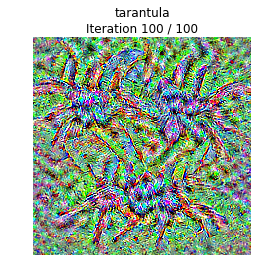

In [19]:
target_y = 76 # Tarantula
out = create_class_visualization(target_y, model)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

Yorkshire terrier
(?, 1000)
(?, ?, ?, 3)
(?, ?, ?, 3)
step:0,current_label_score:15.145923,target_label_score:6.418157


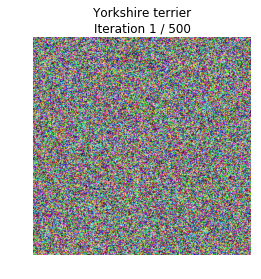

step:1,current_label_score:12.881385,target_label_score:6.587039
step:2,current_label_score:13.682229,target_label_score:7.544940
step:3,current_label_score:14.511890,target_label_score:8.837178
step:4,current_label_score:21.144608,target_label_score:15.070888
step:5,current_label_score:19.468210,target_label_score:13.821421
step:6,current_label_score:28.041996,target_label_score:18.339485
step:7,current_label_score:17.892477,target_label_score:12.804436
step:8,current_label_score:24.178802,target_label_score:20.119247
step:9,current_label_score:23.324574,target_label_score:17.679384
step:10,current_label_score:26.615679,target_label_score:22.782587
step:11,current_label_score:23.604778,target_label_score:20.384186
step:12,current_label_score:21.619263,target_label_score:17.110060
step:13,current_label_score:20.444473,target_label_score:18.409319
step:14,current_label_score:25.997194,target_label_score:22.247429
step:15,current_label_score:26.971674,target_label_score:23.287771
step:16

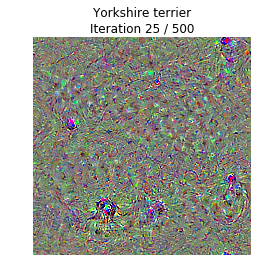

step:25,current_label_score:39.362328,target_label_score:38.225777
step:26,current_label_score:45.591694,target_label_score:45.444469
step:27,current_label_score:45.706043,target_label_score:44.158691
step:28,current_label_score:58.716763,target_label_score:58.716763
step:29,current_label_score:55.879078,target_label_score:54.267902
step:30,current_label_score:60.217224,target_label_score:60.217224
step:31,current_label_score:52.646023,target_label_score:52.646023
step:32,current_label_score:50.994240,target_label_score:50.994240
step:33,current_label_score:46.944889,target_label_score:44.058407
step:34,current_label_score:64.759445,target_label_score:64.759445
step:35,current_label_score:62.848545,target_label_score:62.848545
step:36,current_label_score:70.361725,target_label_score:70.361725
step:37,current_label_score:80.153152,target_label_score:80.153152
step:38,current_label_score:58.503738,target_label_score:58.503738
step:39,current_label_score:78.479408,target_label_score:78.47

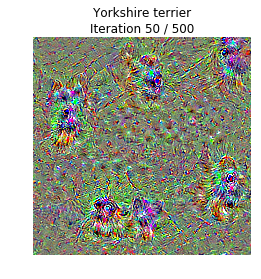

step:50,current_label_score:104.580017,target_label_score:104.580017
step:51,current_label_score:93.313133,target_label_score:93.313133
step:52,current_label_score:87.261871,target_label_score:87.261871
step:53,current_label_score:79.285583,target_label_score:79.285583
step:54,current_label_score:80.614906,target_label_score:80.614906
step:55,current_label_score:85.514305,target_label_score:85.514305
step:56,current_label_score:92.463455,target_label_score:92.463455
step:57,current_label_score:91.537453,target_label_score:91.537453
step:58,current_label_score:77.632584,target_label_score:77.632584
step:59,current_label_score:95.606293,target_label_score:95.606293
step:60,current_label_score:89.743065,target_label_score:89.743065
step:61,current_label_score:93.099358,target_label_score:93.099358
step:62,current_label_score:89.216476,target_label_score:89.216476
step:63,current_label_score:92.900757,target_label_score:92.900757
step:64,current_label_score:85.942780,target_label_score:85.

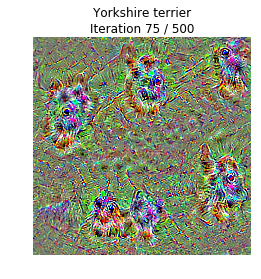

step:75,current_label_score:124.537643,target_label_score:124.537643
step:76,current_label_score:111.230667,target_label_score:111.230667
step:77,current_label_score:96.131744,target_label_score:96.131744
step:78,current_label_score:137.434601,target_label_score:137.434601
step:79,current_label_score:105.613480,target_label_score:105.613480
step:80,current_label_score:131.427002,target_label_score:131.427002
step:81,current_label_score:121.299072,target_label_score:121.299072
step:82,current_label_score:98.738777,target_label_score:98.738777
step:83,current_label_score:109.117996,target_label_score:109.117996
step:84,current_label_score:114.858437,target_label_score:114.858437
step:85,current_label_score:106.483833,target_label_score:106.483833
step:86,current_label_score:133.490219,target_label_score:133.490219
step:87,current_label_score:109.505318,target_label_score:109.505318
step:88,current_label_score:124.324966,target_label_score:124.324966
step:89,current_label_score:132.589645

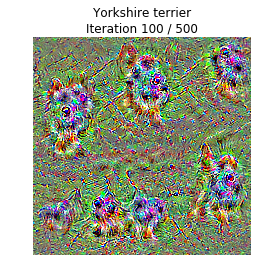

step:100,current_label_score:153.256699,target_label_score:153.256699
step:101,current_label_score:112.594154,target_label_score:112.594154
step:102,current_label_score:115.302605,target_label_score:115.302605
step:103,current_label_score:99.852547,target_label_score:99.852547
step:104,current_label_score:111.970009,target_label_score:111.970009
step:105,current_label_score:145.692627,target_label_score:145.692627
step:106,current_label_score:133.372223,target_label_score:133.372223
step:107,current_label_score:113.819351,target_label_score:113.819351
step:108,current_label_score:115.353249,target_label_score:115.353249
step:109,current_label_score:138.637222,target_label_score:138.637222
step:110,current_label_score:164.377335,target_label_score:164.377335
step:111,current_label_score:129.376266,target_label_score:129.376266
step:112,current_label_score:133.583374,target_label_score:133.583374
step:113,current_label_score:108.058678,target_label_score:108.058678
step:114,current_label

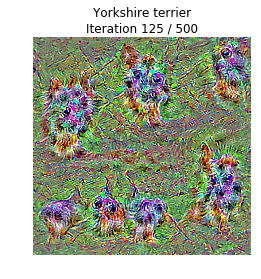

step:125,current_label_score:139.449249,target_label_score:139.449249
step:126,current_label_score:122.902252,target_label_score:122.902252
step:127,current_label_score:125.635330,target_label_score:125.635330
step:128,current_label_score:125.227715,target_label_score:125.227715
step:129,current_label_score:137.095993,target_label_score:137.095993
step:130,current_label_score:133.229095,target_label_score:133.229095
step:131,current_label_score:116.443420,target_label_score:116.443420
step:132,current_label_score:131.384323,target_label_score:131.384323
step:133,current_label_score:123.797928,target_label_score:123.797928
step:134,current_label_score:118.996231,target_label_score:118.996231
step:135,current_label_score:115.099426,target_label_score:115.099426
step:136,current_label_score:136.960358,target_label_score:136.960358
step:137,current_label_score:146.981262,target_label_score:146.981262
step:138,current_label_score:130.358749,target_label_score:130.358749
step:139,current_lab

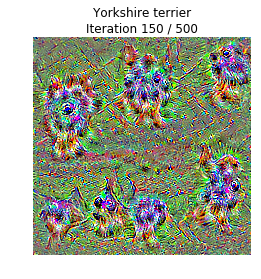

step:150,current_label_score:150.889816,target_label_score:150.889816
step:151,current_label_score:150.978806,target_label_score:150.978806
step:152,current_label_score:114.710381,target_label_score:114.710381
step:153,current_label_score:104.685234,target_label_score:104.685234
step:154,current_label_score:127.473259,target_label_score:127.473259
step:155,current_label_score:123.859398,target_label_score:123.859398
step:156,current_label_score:152.459076,target_label_score:152.459076
step:157,current_label_score:159.353043,target_label_score:159.353043
step:158,current_label_score:128.135361,target_label_score:128.135361
step:159,current_label_score:126.712189,target_label_score:126.712189
step:160,current_label_score:130.386642,target_label_score:130.386642
step:161,current_label_score:111.750130,target_label_score:111.750130
step:162,current_label_score:120.660629,target_label_score:120.660629
step:163,current_label_score:136.204819,target_label_score:136.204819
step:164,current_lab

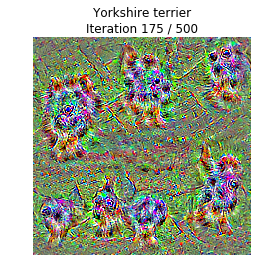

step:175,current_label_score:150.971603,target_label_score:150.971603
step:176,current_label_score:131.495117,target_label_score:131.495117
step:177,current_label_score:110.487511,target_label_score:110.487511
step:178,current_label_score:132.283142,target_label_score:132.283142
step:179,current_label_score:154.250580,target_label_score:154.250580
step:180,current_label_score:154.412979,target_label_score:154.412979
step:181,current_label_score:151.142166,target_label_score:151.142166
step:182,current_label_score:117.781158,target_label_score:117.781158
step:183,current_label_score:155.322906,target_label_score:155.322906
step:184,current_label_score:118.053535,target_label_score:118.053535
step:185,current_label_score:146.522263,target_label_score:146.522263
step:186,current_label_score:130.585663,target_label_score:130.585663
step:187,current_label_score:137.352493,target_label_score:137.352493
step:188,current_label_score:156.655624,target_label_score:156.655624
step:189,current_lab

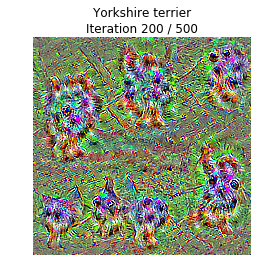

step:200,current_label_score:168.134216,target_label_score:168.134216
step:201,current_label_score:159.156113,target_label_score:159.156113
step:202,current_label_score:117.922958,target_label_score:117.922958
step:203,current_label_score:95.343048,target_label_score:95.343048
step:204,current_label_score:147.764725,target_label_score:147.764725
step:205,current_label_score:145.164948,target_label_score:145.164948
step:206,current_label_score:142.026047,target_label_score:142.026047
step:207,current_label_score:104.127586,target_label_score:104.127586
step:208,current_label_score:140.260315,target_label_score:140.260315
step:209,current_label_score:133.813263,target_label_score:133.813263
step:210,current_label_score:154.031586,target_label_score:154.031586
step:211,current_label_score:148.847977,target_label_score:148.847977
step:212,current_label_score:120.128075,target_label_score:120.128075
step:213,current_label_score:134.748291,target_label_score:134.748291
step:214,current_label

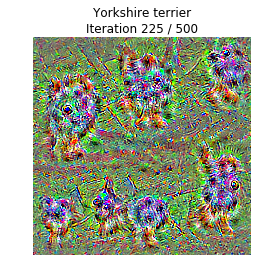

step:225,current_label_score:152.205978,target_label_score:152.205978
step:226,current_label_score:114.832397,target_label_score:114.832397
step:227,current_label_score:157.054016,target_label_score:157.054016
step:228,current_label_score:171.791885,target_label_score:171.791885
step:229,current_label_score:184.685394,target_label_score:184.685394
step:230,current_label_score:153.007874,target_label_score:153.007874
step:231,current_label_score:172.980957,target_label_score:172.980957
step:232,current_label_score:165.965927,target_label_score:165.965927
step:233,current_label_score:96.295555,target_label_score:96.295555
step:234,current_label_score:119.881020,target_label_score:119.881020
step:235,current_label_score:157.009506,target_label_score:157.009506
step:236,current_label_score:152.853729,target_label_score:152.853729
step:237,current_label_score:126.280014,target_label_score:126.280014
step:238,current_label_score:160.925415,target_label_score:160.925415
step:239,current_label

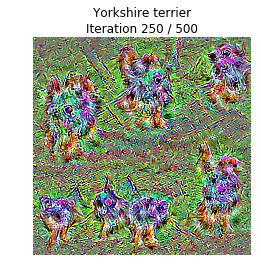

step:250,current_label_score:147.869110,target_label_score:147.869110
step:251,current_label_score:145.845337,target_label_score:145.845337
step:252,current_label_score:139.300079,target_label_score:139.300079
step:253,current_label_score:122.039627,target_label_score:122.039627
step:254,current_label_score:157.389175,target_label_score:157.389175
step:255,current_label_score:136.749817,target_label_score:136.749817
step:256,current_label_score:152.896667,target_label_score:152.896667
step:257,current_label_score:174.492615,target_label_score:174.492615
step:258,current_label_score:154.394318,target_label_score:154.394318
step:259,current_label_score:183.615585,target_label_score:183.615585
step:260,current_label_score:155.357956,target_label_score:155.357956
step:261,current_label_score:158.933075,target_label_score:158.933075
step:262,current_label_score:127.586449,target_label_score:127.586449
step:263,current_label_score:129.706711,target_label_score:129.706711
step:264,current_lab

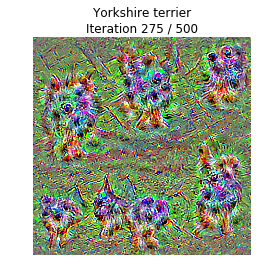

step:275,current_label_score:165.573624,target_label_score:165.573624
step:276,current_label_score:175.714691,target_label_score:175.714691
step:277,current_label_score:142.459198,target_label_score:142.459198
step:278,current_label_score:166.123077,target_label_score:166.123077
step:279,current_label_score:156.521591,target_label_score:156.521591
step:280,current_label_score:126.914627,target_label_score:126.914627
step:281,current_label_score:137.545853,target_label_score:137.545853
step:282,current_label_score:151.172363,target_label_score:151.172363
step:283,current_label_score:143.304382,target_label_score:143.304382
step:284,current_label_score:159.619888,target_label_score:159.619888
step:285,current_label_score:171.046524,target_label_score:171.046524
step:286,current_label_score:160.959442,target_label_score:160.959442
step:287,current_label_score:144.273087,target_label_score:144.273087
step:288,current_label_score:156.262726,target_label_score:156.262726
step:289,current_lab

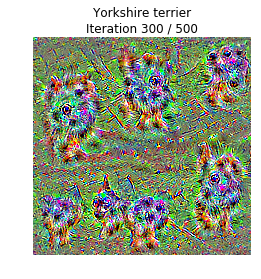

step:300,current_label_score:167.203125,target_label_score:167.203125
step:301,current_label_score:158.677811,target_label_score:158.677811
step:302,current_label_score:120.891571,target_label_score:120.891571
step:303,current_label_score:102.346939,target_label_score:102.346939
step:304,current_label_score:138.960938,target_label_score:138.960938
step:305,current_label_score:143.749039,target_label_score:143.749039
step:306,current_label_score:135.072479,target_label_score:135.072479
step:307,current_label_score:173.492111,target_label_score:173.492111
step:308,current_label_score:152.481735,target_label_score:152.481735
step:309,current_label_score:172.260376,target_label_score:172.260376
step:310,current_label_score:161.869171,target_label_score:161.869171
step:311,current_label_score:186.049057,target_label_score:186.049057
step:312,current_label_score:120.641235,target_label_score:120.641235
step:313,current_label_score:135.730774,target_label_score:135.730774
step:314,current_lab

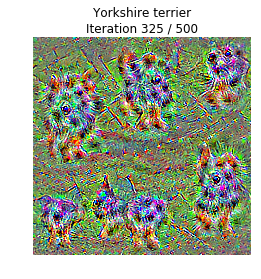

step:325,current_label_score:151.752975,target_label_score:151.752975
step:326,current_label_score:166.298752,target_label_score:166.298752
step:327,current_label_score:178.939133,target_label_score:178.939133
step:328,current_label_score:128.743027,target_label_score:128.743027
step:329,current_label_score:163.948807,target_label_score:163.948807
step:330,current_label_score:165.264893,target_label_score:165.264893
step:331,current_label_score:163.330902,target_label_score:163.330902
step:332,current_label_score:144.945068,target_label_score:144.945068
step:333,current_label_score:162.550690,target_label_score:162.550690
step:334,current_label_score:145.048798,target_label_score:145.048798
step:335,current_label_score:172.712143,target_label_score:172.712143
step:336,current_label_score:107.008347,target_label_score:107.008347
step:337,current_label_score:166.740250,target_label_score:166.740250
step:338,current_label_score:150.618866,target_label_score:150.618866
step:339,current_lab

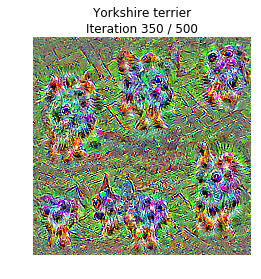

step:350,current_label_score:156.778656,target_label_score:156.778656
step:351,current_label_score:154.637405,target_label_score:154.637405
step:352,current_label_score:166.722443,target_label_score:166.722443
step:353,current_label_score:156.908875,target_label_score:156.908875
step:354,current_label_score:130.534088,target_label_score:130.534088
step:355,current_label_score:166.084854,target_label_score:166.084854
step:356,current_label_score:178.804169,target_label_score:178.804169
step:357,current_label_score:157.268555,target_label_score:157.268555
step:358,current_label_score:144.822067,target_label_score:144.822067
step:359,current_label_score:200.260834,target_label_score:200.260834
step:360,current_label_score:174.004608,target_label_score:174.004608
step:361,current_label_score:164.384125,target_label_score:164.384125
step:362,current_label_score:156.996582,target_label_score:156.996582
step:363,current_label_score:127.465630,target_label_score:127.465630
step:364,current_lab

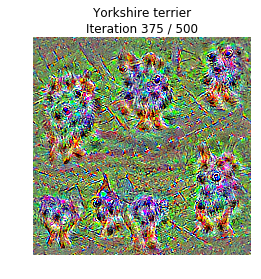

step:375,current_label_score:165.251785,target_label_score:165.251785
step:376,current_label_score:157.922638,target_label_score:157.922638
step:377,current_label_score:160.850021,target_label_score:160.850021
step:378,current_label_score:148.686264,target_label_score:148.686264
step:379,current_label_score:163.974503,target_label_score:163.974503
step:380,current_label_score:196.002792,target_label_score:196.002792
step:381,current_label_score:185.429382,target_label_score:185.429382
step:382,current_label_score:134.178665,target_label_score:134.178665
step:383,current_label_score:126.181442,target_label_score:126.181442
step:384,current_label_score:131.983063,target_label_score:131.983063
step:385,current_label_score:162.163589,target_label_score:162.163589
step:386,current_label_score:151.686218,target_label_score:151.686218
step:387,current_label_score:153.069824,target_label_score:153.069824
step:388,current_label_score:159.434631,target_label_score:159.434631
step:389,current_lab

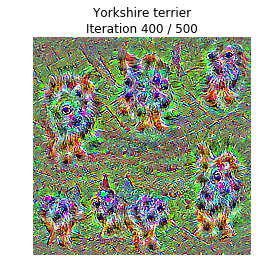

step:400,current_label_score:165.975433,target_label_score:165.975433
step:401,current_label_score:146.385498,target_label_score:146.385498
step:402,current_label_score:140.460541,target_label_score:140.460541
step:403,current_label_score:148.070587,target_label_score:148.070587
step:404,current_label_score:136.141602,target_label_score:136.141602
step:405,current_label_score:160.715393,target_label_score:160.715393
step:406,current_label_score:128.735779,target_label_score:128.735779
step:407,current_label_score:171.366089,target_label_score:171.366089
step:408,current_label_score:180.017456,target_label_score:180.017456
step:409,current_label_score:172.302078,target_label_score:172.302078
step:410,current_label_score:174.046906,target_label_score:174.046906
step:411,current_label_score:145.269073,target_label_score:145.269073
step:412,current_label_score:145.493118,target_label_score:145.493118
step:413,current_label_score:156.622406,target_label_score:156.622406
step:414,current_lab

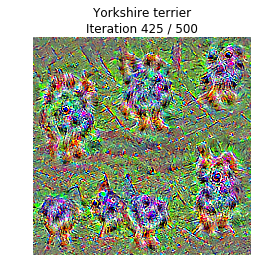

step:425,current_label_score:135.828857,target_label_score:135.828857
step:426,current_label_score:162.353943,target_label_score:162.353943
step:427,current_label_score:142.974045,target_label_score:142.974045
step:428,current_label_score:165.019287,target_label_score:165.019287
step:429,current_label_score:167.863586,target_label_score:167.863586
step:430,current_label_score:173.450821,target_label_score:173.450821
step:431,current_label_score:167.742371,target_label_score:167.742371
step:432,current_label_score:125.509995,target_label_score:125.509995
step:433,current_label_score:129.299332,target_label_score:129.299332
step:434,current_label_score:136.194061,target_label_score:136.194061
step:435,current_label_score:162.626602,target_label_score:162.626602
step:436,current_label_score:134.625122,target_label_score:134.625122
step:437,current_label_score:138.688080,target_label_score:138.688080
step:438,current_label_score:189.588806,target_label_score:189.588806
step:439,current_lab

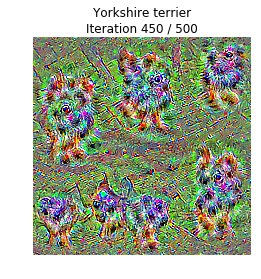

step:450,current_label_score:150.956390,target_label_score:150.956390
step:451,current_label_score:157.103455,target_label_score:157.103455
step:452,current_label_score:154.655945,target_label_score:154.655945
step:453,current_label_score:185.391510,target_label_score:185.391510
step:454,current_label_score:159.377274,target_label_score:159.377274
step:455,current_label_score:166.425018,target_label_score:166.425018
step:456,current_label_score:155.293945,target_label_score:155.293945
step:457,current_label_score:164.123840,target_label_score:164.123840
step:458,current_label_score:125.291786,target_label_score:125.291786
step:459,current_label_score:147.599075,target_label_score:147.599075
step:460,current_label_score:182.781982,target_label_score:182.781982
step:461,current_label_score:168.416397,target_label_score:168.416397
step:462,current_label_score:175.574768,target_label_score:175.574768
step:463,current_label_score:160.565613,target_label_score:160.565613
step:464,current_lab

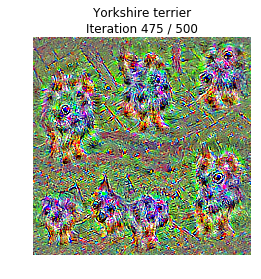

step:475,current_label_score:139.570053,target_label_score:139.570053
step:476,current_label_score:162.958252,target_label_score:162.958252
step:477,current_label_score:145.501266,target_label_score:145.501266
step:478,current_label_score:183.804047,target_label_score:183.804047
step:479,current_label_score:161.246994,target_label_score:161.246994
step:480,current_label_score:151.155029,target_label_score:151.155029
step:481,current_label_score:141.278870,target_label_score:141.278870
step:482,current_label_score:143.639038,target_label_score:143.639038
step:483,current_label_score:144.182510,target_label_score:144.182510
step:484,current_label_score:106.513901,target_label_score:106.513901
step:485,current_label_score:158.289551,target_label_score:158.289551
step:486,current_label_score:178.914856,target_label_score:178.914856
step:487,current_label_score:141.812622,target_label_score:141.812622
step:488,current_label_score:174.503632,target_label_score:174.503632
step:489,current_lab

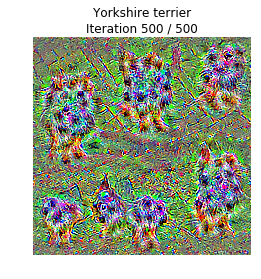

In [27]:
target_y = np.random.randint(1000)
target_y = 78 # Tick
target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
print(class_names[target_y])
X = create_class_visualization(target_y, model)